In [1]:
import pandas as pd
import torch  # because we save the data as torch tensors
import os
import time
import numpy as np
from joblib import Parallel, delayed # to parallelize processing the ECGs, so that it all runs faster
# info: in parallel mode print-statements are ignored. That is why functions that are run parallel should instead return a message
import neurokit2 as nk # for neurokit features
import heartpy as hp # for heartpy features

import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, accuracy_score
import shap # for XAI xgboost
import matplotlib.pyplot as plt
from functools import reduce

import config

# some settings and variables here show the experiments that were done. You may ignore them when recreating our work.

USE_HEARTPY_FEATURES = True
USE_HRV_FEATURES = True
USE_BASIC_FEATURES = True

HEARTPY_USE_MEDIAN_INSTEAD_OF_MEAN = False
BALANCE_TRAINSET = True
APPLY_WEIGHTS = False

RECREATE_FEATURE_DF = False # if you don't want to use dataframes created by previous runs of this file

name_appendix = f'hrv_{str(USE_HRV_FEATURES)}_heartpy_{USE_HEARTPY_FEATURES}'#_balanced_{BALANCE_TRAINSET}'
if HEARTPY_USE_MEDIAN_INSTEAD_OF_MEAN:
    name_appendix += '_MEDIAN'
if USE_BASIC_FEATURES:
    name_appendix += '_with_basic_features'

use_only_cpu = True # in case you don't want to use GPU or don't have GPU for xgboost training
start_time = time.time()

set_df_pathnames = [] # where the metadata-files for train-val-test are stored
for set in config.SPLIT_NAMES:
    set_df_pathnames.append(os.path.join(config.OUT_FOLDER, set + '_df.csv'))


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# get features
# this takes ~46 minutes with i5-1240p if you activate all feature sets
# there are some errors during feature creation: workers stopped in parallel calls and there are problems during feature extraction for a minority of files

in_parallel = True # set to False for debugging

if (not USE_HRV_FEATURES) and (not USE_HEARTPY_FEATURES) and (not USE_BASIC_FEATURES):
    raise('Cannot create features! No feature-set was chosen!')


def get_heartbeat_features(tensor_file, label, create_hrv_features, create_heartpy_features, create_basic_features):
    msg=''
    data_hrv = pd.DataFrame()
    data_basic = pd.DataFrame()
    data_heartpy = pd.DataFrame()
    data = []
    try:
        ecg_signal = torch.load(tensor_file).numpy().squeeze()

        if create_hrv_features or create_basic_features:
            # analyse the ecg-signal with neurokit2
            peaks, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=config.SAMPLING_RATE)
        
        if create_hrv_features:
            data_hrv = nk.hrv(peaks, sampling_rate=config.SAMPLING_RATE, show=False)
        
        if create_basic_features:
            _, waves_peak_info = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=config.SAMPLING_RATE, method="dwt")
            waves_peak_info.update(rpeaks)
            waves_peak_info_original_keys = list(waves_peak_info.keys())
            # convert lists to numpy arrays
            for elem in waves_peak_info:
                waves_peak_info[elem] = np.array(waves_peak_info[elem])

            waves_peak_info['interval_p_ms'] = ((waves_peak_info['ECG_P_Offsets'] - waves_peak_info['ECG_P_Onsets']))*1000/config.SAMPLING_RATE
            waves_peak_info['interval_pq_ms'] = ((waves_peak_info['ECG_Q_Peaks'] - waves_peak_info['ECG_P_Onsets']))*1000/config.SAMPLING_RATE
            waves_peak_info['interval_qrs_ms'] = ((waves_peak_info['ECG_S_Peaks'] - waves_peak_info['ECG_Q_Peaks']))*1000/config.SAMPLING_RATE
            waves_peak_info['interval_qt_ms'] = ((waves_peak_info['ECG_T_Peaks'] - waves_peak_info['ECG_Q_Peaks']))*1000/config.SAMPLING_RATE
            waves_peak_info['interval_t_ms'] = ((waves_peak_info['ECG_T_Offsets'] - waves_peak_info['ECG_T_Onsets']))*1000/config.SAMPLING_RATE

            # remove indices that are nan to get valid amplitudes and remove nan-intervals
            for elem in waves_peak_info:
                waves_peak_info[elem] = waves_peak_info[elem][~np.isnan(waves_peak_info[elem])]

            waves_peak_info['p_mV'] = (ecg_signal[waves_peak_info['ECG_P_Peaks'].astype(int)]) if waves_peak_info['ECG_P_Peaks'].any() else np.nan
            waves_peak_info['q_mV'] = (ecg_signal[waves_peak_info['ECG_Q_Peaks'].astype(int)]) if waves_peak_info['ECG_Q_Peaks'].any() else np.nan
            waves_peak_info['r_mV'] = (ecg_signal[waves_peak_info['ECG_R_Peaks'].astype(int)]) if waves_peak_info['ECG_R_Peaks'].any() else np.nan
            waves_peak_info['s_mV'] = (ecg_signal[waves_peak_info['ECG_S_Peaks'].astype(int)]) if waves_peak_info['ECG_S_Peaks'].any() else np.nan
            waves_peak_info['t_mV'] = (ecg_signal[waves_peak_info['ECG_T_Peaks'].astype(int)]) if waves_peak_info['ECG_T_Peaks'].any() else np.nan

            # mean heartbeat-wise features
            for elem in waves_peak_info:
                waves_peak_info[elem] = np.mean(waves_peak_info[elem])

            features_dict = waves_peak_info
            for key in waves_peak_info_original_keys:
                if key in waves_peak_info:
                    features_dict.pop(key, None)
            data_basic = pd.DataFrame.from_dict([features_dict])

        if create_heartpy_features:
            working_data, measures = hp.process(ecg_signal, config.SAMPLING_RATE) # returns 2 dicts, delivers data per peak
            data_measures = pd.DataFrame([measures]) # measures contains features per sample-data
            data_working = pd.DataFrame([working_data]) # working_data contains feature-values per-heartbeat
            # --> mean the per-heartbeat features so that we have features per-subject
            # taking mean of values of the poincare feature-dict (which is inside the data_working-dict)
            poincare_dict = data_working['poincare'][0]
            poincare_col_name_list = ['x_plus', 'x_minus', 'x_one', 'x_two']
            poincare_col_name_values_list = []
            for col_name in poincare_col_name_list:
                if HEARTPY_USE_MEDIAN_INSTEAD_OF_MEAN:
                    poincare_col_name_values_list.append(np.median(poincare_dict[col_name]))
                else:
                    poincare_col_name_values_list.append(np.mean(poincare_dict[col_name]))

            # taking mean of the lists in the dict
            tuples_to_change = ['hr', 'rolling_mean', 'RR_list', 'RR_diff', 'RR_sqdiff', 'binary_peaklist']
            col_name_list = tuples_to_change + ['ybeat','RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'breathing_signal', 'breathing_psd','breathing_frq']
            col_names_values_list = []
            for col_name in col_name_list:
                if HEARTPY_USE_MEDIAN_INSTEAD_OF_MEAN:
                    col_names_values_list.append(np.median(np.array(data_working[col_name][0])))
                else:
                    col_names_values_list.append(np.mean(np.array(data_working[col_name][0])))
            
            # drop columns that have been dealt with or that contain unusuable indice information
            columns_to_drop = col_name_list + ['peaklist', 'RR_indices', 'removed_beats', 'removed_beats_y', 'poincare']
            for col_to_drop in columns_to_drop:
                if col_to_drop in data_working.columns:
                    data_working = data_working.drop(columns=[col_to_drop])
                        
            data_working = np.mean(data_working, axis=0) #these values include sample rate and so on --> they have neither mean nor median...
            # append the other stuff
            for idx, col_name in enumerate(poincare_col_name_list):
                data_working[col_name] = poincare_col_name_values_list[idx]

            for idx, col_name in enumerate(col_name_list):
                data_working[col_name] = col_names_values_list[idx]
            
            # concat measures and working dict
            data_heartpy = pd.concat([data_measures, pd.DataFrame(data_working).transpose()], axis=1)

        # add label and source file to the different feature-sets
        data_hrv[config.TENSOR_FILE_COLUMN_NAME] = tensor_file
        data_hrv[config.LABEL_COLUMN_NAME] = label
        data_heartpy[config.TENSOR_FILE_COLUMN_NAME] = tensor_file
        data_heartpy[config.LABEL_COLUMN_NAME] = label        
        data_basic[config.TENSOR_FILE_COLUMN_NAME] = tensor_file
        data_basic[config.LABEL_COLUMN_NAME] = label
    except Exception as e:
        msg = e
    return tensor_file, msg, data_hrv, data_heartpy, data_basic


full_feature_set_list =[]
for set_df_pathname, set_name in zip(set_df_pathnames, config.SPLIT_NAMES):
    set_df = pd.read_csv(set_df_pathname)

    hrv_df_save_name = os.path.join(config.OUT_FOLDER, (set_name + '_df_hrv_features.csv'))
    heartpy_df_save_name = os.path.join(config.OUT_FOLDER, (set_name + '_df_heartpy_features.csv'))
    basic_df_save_name = os.path.join(config.OUT_FOLDER, (set_name + '_df_basic_features.csv'))
    # what feature dfs need to be created and which already exist?
    create_hrv_features = USE_HRV_FEATURES
    create_heartpy_features = USE_HEARTPY_FEATURES
    create_basic_features = USE_BASIC_FEATURES
    if RECREATE_FEATURE_DF:
        create_hrv_features = True
        create_heartpy_features = True
        create_basic_features = True
    else:
        if USE_HRV_FEATURES:
            if os.path.exists(hrv_df_save_name):
                create_hrv_features = False
                print(f'for {set_name}-set: will load existing hrv-feature set')
        if USE_HEARTPY_FEATURES:
            if os.path.exists(heartpy_df_save_name):
                create_heartpy_features = False
                print(f'for {set_name}-set: will load existing heartpy-feature set')
        if USE_BASIC_FEATURES:
            if os.path.exists(basic_df_save_name):
                create_basic_features = False
                print(f'for {set_name}-set: will load existing basic-feature set')
    # need to create anything?
    if create_hrv_features or create_heartpy_features or create_basic_features:
        t1= time.time()
        if in_parallel:
            results = Parallel(n_jobs= os.cpu_count())(delayed(get_heartbeat_features)(row[config.TENSOR_FILE_COLUMN_NAME], row[config.LABEL_COLUMN_NAME], create_hrv_features, 
                                                                                    create_heartpy_features, create_basic_features) for idx, row in set_df.iterrows())
        else:
            results = []
            for idx, row in set_df.iterrows():
                results.append(get_heartbeat_features(row[config.TENSOR_FILE_COLUMN_NAME], row[config.LABEL_COLUMN_NAME], create_hrv_features, create_heartpy_features, create_basic_features))

        t2= time.time()
        print(f'generating ecg features lists for {set_name} took {t2-t1} seconds. It has {len(results)} results')
        hrv_features_list = []
        heartpy_features_list = []
        basic_features_list = []
        for tensor_file, msg, data_hrv, data_heartpy, data_basic in results:
            if msg != '':
                print(msg)
                print(tensor_file)
            else:
                hrv_features_list.append(data_hrv)
                heartpy_features_list.append(data_heartpy)
                basic_features_list.append(data_basic)

        if create_hrv_features:
            hrv_features_df = pd.concat(hrv_features_list)
            hrv_features_df.to_csv(hrv_df_save_name, index=False)
        if create_heartpy_features:
            hrv_features_df = pd.concat(heartpy_features_list)
            hrv_features_df.to_csv(heartpy_df_save_name, index=False)
        if create_basic_features:
            hrv_features_df = pd.concat(basic_features_list)
            hrv_features_df.to_csv(basic_df_save_name, index=False)

    # feature set has either just been created or already exists. Load feature-sets
    df_list = []
    for df_name, want_df in zip([hrv_df_save_name, heartpy_df_save_name, basic_df_save_name], [USE_HRV_FEATURES, USE_HEARTPY_FEATURES, USE_BASIC_FEATURES]):
        if want_df:
            df = pd.read_csv(df_name)

            # change labels according to the bin-merge-dict --> easier to do now, then no need to get the features again
            for old_label, new_label in config.BIN_MERGE_DICT.items():
                df.loc[df[config.LABEL_COLUMN_NAME] == old_label, config.LABEL_COLUMN_NAME] = new_label
                
            df_list.append(df)
    # now merge feature sets
    full_feature_set = reduce(lambda  left,right: pd.merge(left,right,on=config.TENSOR_FILE_COLUMN_NAME, how='inner'), df_list)

    # now there exist identical columns. Drop them! Plus do away with columns that serve no use in the classification
    columns_to_drop = ['Age_group_x','Age_group_y', config.TENSOR_FILE_COLUMN_NAME, 'segment_indices']
    if USE_BASIC_FEATURES and USE_HEARTPY_FEATURES:
        columns_to_drop.append('ybeat') # otherwise it is twice in the data in the form of ybeat and r_mV
    for col_to_drop in columns_to_drop:
        if col_to_drop in full_feature_set.columns:
            full_feature_set = full_feature_set.drop(columns=[col_to_drop])

    # replace NaN-features with 0 (unfortunately there always are some NaN-features)
    print(f'Info: {full_feature_set.isna().sum().sum()} NaN-values were found. Replacing them with 0')
    full_feature_set = full_feature_set.fillna(0)
    
    # add 'SR_'-prefix to short range features. The long range features already have the HRV-prefix.
    full_feature_set_back = full_feature_set.copy()
    for col in full_feature_set_back.columns:
        if not (col.startswith("HRV_") or (col == "tensor_file") or (col == "Age_group")):
            new_col_name = 'SR_' + col
            full_feature_set.rename({col: new_col_name}, axis=1, inplace=True)
    # full_feature_set.to_csv('test.csv') # to see if everything is as expected
    full_feature_set_list.append(full_feature_set)

for test-set: will load existing hrv-feature set
for test-set: will load existing heartpy-feature set
for test-set: will load existing basic-feature set
Info: 260 NaN-values were found. Replacing them with 0
for val-set: will load existing hrv-feature set
for val-set: will load existing heartpy-feature set
for val-set: will load existing basic-feature set
Info: 261 NaN-values were found. Replacing them with 0
for train-set: will load existing hrv-feature set
for train-set: will load existing heartpy-feature set
for train-set: will load existing basic-feature set
Info: 809 NaN-values were found. Replacing them with 0


In [3]:
if use_only_cpu:
    params = {"objective": "multi:softprob", "tree_method": "hist", "num_class": config.NUM_CLASSES} # if cpu is used for training
else:
    params = {"objective": "multi:softprob", "tree_method": "gpu_hist", "num_class": config.NUM_CLASSES} # with this gpu is used for training


In [4]:
# use xgboost on the features

xgb_DMatrix_list = [] # contains the filtered feature dataframes as a DMatrix. First element in the list is test, then val then train

for feature_df, set_name in zip(full_feature_set_list, config.SPLIT_NAMES):
    x, y = feature_df.drop(config.LABEL_COLUMN_NAME, axis=1), feature_df[[config.LABEL_COLUMN_NAME]] -1 # -1 so that the labels start at 0 because for xgboost labels MUST start at 0

    #balance training set
    if (set_name == 'train') and BALANCE_TRAINSET:
        ros = RandomOverSampler(random_state=42)
        x, y = ros.fit_resample(x, y) # copys elements of minority-classes until they have the same number of samples as the minority classes

    # there is no categorical data, only numbers (but y is a categorical label)
    cats = x.select_dtypes(exclude=np.number).columns.tolist() # get categorical data columns that we may have missed
    if cats:
        # features 'sdsd' is for some reason type object, converting it
        print(f'found categorical data in dataframe, columns: {cats}. Converting it to float')
        for elem in cats:
            x[elem] = x[elem].astype(str).str.extract('(\d+.\d+)', expand=False).astype('float')

    # Create classification matrices
    xgb_DMatrix_list.append(xgb.DMatrix(x, y, enable_categorical=False))

dtest_clf = xgb_DMatrix_list[0]
dval_clf = xgb_DMatrix_list[1]
dtrain_clf = xgb_DMatrix_list[2]

found categorical data in dataframe, columns: ['SR_sdsd']. Converting it to float


In [5]:
# get training weights (not necessary when we do oversampling to balance out the dataset)

y_train = dtrain_clf.get_label()
class_weight_list = []
for val in config.AGE_GROUPS:
    num_occurences_class = 0
    num_occurences_class = np.count_nonzero(y_train == (val-1))
    
    if num_occurences_class == 0:
        num_occurences_class = 1 # to avoid inf-weights
    
    class_weight_list.append(num_occurences_class)

class_weight_array = np.array(class_weight_list) / len(y_train) # contains relative percentages of the labels in the train set
class_weights = 1 / class_weight_array  # value class more if it is underrepresented

# weights must be sample-level
sample_weights_list = []
class_weights = class_weights.squeeze()
for label in y_train.squeeze():
    sample_weights_list.append(class_weights[int(label)-1])

sample_weights = np.array(sample_weights_list)

if APPLY_WEIGHTS:
    dtrain_clf.set_weight(sample_weights)
    #print(dtrain_clf.get_weight())

In [6]:
# using cv to find good parameters instead of grid search: https://stackoverflow.com/questions/68766331/how-to-apply-predict-to-xgboost-cross-validation

DO_PARAMETER_SEARCH = False # set to True if there is time for a parameter search. Warning: It REALLY does take a long time. Even this very simple grid took me ~1h to run

if DO_PARAMETER_SEARCH: # manual grid search
   #grid = pd.DataFrame({'eta':[0.01,0.05,0.1]*5, 'subsample': np.repeat([0.2,0.4,0.6,0.8,1.0],3)})
   grid = pd.DataFrame({'max_depth':[15,20]*2, 'max_leaves': np.repeat([15,20],2)})

   def fit(x):
      params = {
               'eval_metric':'mlogloss',
               "objective": "multi:softprob",
               "tree_method": "hist" if use_only_cpu else "gpu_hist",
               "num_class": config.NUM_CLASSES,
               'max_depth':x[0],
               'max_leaves':x[1],
               }

      n = 1000
      cvresult = xgb.cv( # cv = cross-validation
         params,
         dtrain_clf,
         num_boost_round=n,
         nfold=5,
         metrics=["mlogloss"],
         early_stopping_rounds = 11,
         seed=42,
      )
      print(f'number of trees for max_depth {x[0]} and max_leaves {x[1]}: {cvresult.shape[0]}. Score: {cvresult[-1:].values[0]}')
      returnrow = cvresult[-1:].values[0]
      returnrow = np.append(returnrow, [x[0], x[1]])
      return returnrow

   grid[['train-logloss-mean','train-logloss-std','test-logloss-mean','test-logloss-std', 'max_depth', 'max_leaves']] = grid.apply(fit,axis=1,result_type='expand')
   grid = grid.reset_index(drop=True)
   print(grid)
   best_row = grid.loc[grid['test-logloss-mean'].idxmax()]
   extra_params = {
            'max_depth': best_row['max_depth'],
            'max_leaves': best_row['max_leaves']
            }
   params = params.update(extra_params)

In [7]:
params = {
        'eval_metric':'mlogloss',
        "objective": "multi:softprob",
        "tree_method": "hist" if use_only_cpu else "gpu_hist",
        "num_class": config.NUM_CLASSES,
        #'num_parallel_tree': 8,
        'max_depth':10,
        'max_leaves':10,
        'learning_rate': 0.008,
        #'min_split_loss': 0.5
        }

evals = [(dtrain_clf, "train"), (dval_clf, "validation")]
n = 2000
xgboost_model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50, # Every x rounds
   early_stopping_rounds=50 # Activate early stopping to avoid running unneccessarly long. If validation loss does not improve for 100 consecutive rounds it stops
)
# fetch the model with the least loss on the validation set
#best_iteration = xgboost_model.best_iteration

print(f'best validation mlogloss: {xgboost_model.best_score}')


[0]	train-mlogloss:2.68267	validation-mlogloss:2.70026
[50]	train-mlogloss:1.86418	validation-mlogloss:2.44834
[100]	train-mlogloss:1.41830	validation-mlogloss:2.30701
[150]	train-mlogloss:1.12218	validation-mlogloss:2.19578
[200]	train-mlogloss:0.90602	validation-mlogloss:2.11874
[250]	train-mlogloss:0.74631	validation-mlogloss:2.05773
[300]	train-mlogloss:0.62206	validation-mlogloss:2.00756
[350]	train-mlogloss:0.52443	validation-mlogloss:1.97096
[400]	train-mlogloss:0.44733	validation-mlogloss:1.94345
[450]	train-mlogloss:0.38490	validation-mlogloss:1.91993
[500]	train-mlogloss:0.33309	validation-mlogloss:1.90028
[550]	train-mlogloss:0.28995	validation-mlogloss:1.88091
[600]	train-mlogloss:0.25392	validation-mlogloss:1.86635
[650]	train-mlogloss:0.22348	validation-mlogloss:1.85373
[700]	train-mlogloss:0.19779	validation-mlogloss:1.84547
[750]	train-mlogloss:0.17623	validation-mlogloss:1.84062
[800]	train-mlogloss:0.15757	validation-mlogloss:1.83766
[850]	train-mlogloss:0.14153	valid

In [8]:
# save the model for later reference
#xgboost_model.save_model(os.path.join(config.OUT_FOLDER, f'xgboost_model_{name_appendix}_balanced_{BALANCE_TRAINSET}.json'))

#xgboost_model.load_model('xgboost_model.json')

# get the best model's prediction for val and test set
y_val_preds = xgboost_model.predict(dval_clf, iteration_range=(0, xgboost_model.best_iteration + 1))
y_val_trues = dval_clf.get_label()
y_test_preds = xgboost_model.predict(dtest_clf, iteration_range=(0, xgboost_model.best_iteration + 1))
y_test_trues = dtest_clf.get_label()

# get non-probability prediction for confusion matrices
y_preds = [np.argmax(i) for i in y_val_preds] # our prediction is the class with the highest probability according to the model
y_preds = np.array(y_preds)
#print(multilabel_confusion_matrix(y_val_trues, y_preds, labels=labels))

In [9]:
# get AUC score for each class

SHOW_INDIVIDUAL_LABEL_SCORE = True

def get_AUCs(y_preds, y_trues, labels):
    auc_score_list = []
    for label in labels:
        my_label = int(label)
        msg = ''

        # get prediction for label out of the prediction-array for each sample
        y_set_preds_for_label = [i[my_label] for i in y_preds] # is this really necessary? Yes, otherwise: "Number of classes in y_true not equal to the number of columns in 'y_score'""

        # create trues-array. E.g.: before: label = 2. Then: label = [0, 0, 1, 0, 0, 0, ...]
        y_set_trues_for_label = np.zeros(len(y_trues))
        for idx, i in enumerate(y_trues):
            if i == label:
                y_set_trues_for_label[idx] = 1
        
        # are there any samples at all?
        if sum(y_set_trues_for_label) > 0:
            roc_auc_val = roc_auc_score(y_set_trues_for_label, y_set_preds_for_label, multi_class='ovr')
            auc_score_list.append(roc_auc_val)
        else:
            msg = f'label: {my_label+1}: cannot compute AUC for label as there is no sample with this label in the val-set'

    # compute macro-AUC
    auc_score_array = np.array(auc_score_list)
    macro_auc = np.mean(auc_score_array)
    return auc_score_array, macro_auc, msg


labels = np.fromiter(config.AGE_GROUPS, dtype=float)-1

val_preds_trues_list = [y_val_preds, y_val_trues]
test_preds_trues_list = [y_test_preds, y_test_trues]

for set_preds_trues_list, set_name in zip([val_preds_trues_list, test_preds_trues_list], ['val', 'test']):
    y_preds = set_preds_trues_list[0]
    y_trues = set_preds_trues_list[1]
    auc_score_array, macro_auc, msg = get_AUCs(y_preds, y_trues, labels)
    if msg != '':
        print(msg)
    print(f'macro_auc {set_name}: {macro_auc}')
    if SHOW_INDIVIDUAL_LABEL_SCORE:
        print(f'individual scores: {auc_score_array}')


label: 15: cannot compute AUC for label as there is no sample with this label in the val-set
macro_auc val: 0.6798194667731673
individual scores: [0.6741453  0.67839241 0.60516796 0.60617104 0.55741627 0.77536232
 0.66038647 0.72995169 0.62149533 0.88970588]
label: 15: cannot compute AUC for label as there is no sample with this label in the val-set
macro_auc test: 0.6642325381574088
individual scores: [0.54126984 0.69638448 0.59093231 0.48003848 0.62751323 0.49665072
 0.82583732 0.83205742 0.61046512 0.94117647]


In [10]:
# need accuracy for combined age groups just as source (6) did
def get_accuracy_combined_bins(y_preds, y_trues):
    # source: Age Prediction in Healthy Subjects Using RR Intervals and Heart Rate Variability: A Pilot Study Based on Deep Learning
    # source age groups:  18-29y (bin 1-3), 30-39y (bin 4-5), 40-49y (bin 6-7), 50y+ (bin 8-15)
    # take as prediction the highest-probability label, then compute accuracy
    y_preds_adjusted = []
    y_set_preds = y_preds
    for idx, elem in enumerate(y_trues):
        pred_as_int = int(y_set_preds[idx])
        if elem <= 3: #age group "1" 18-29y (bin 1-3)
            if pred_as_int <= 3:
                y_preds_adjusted.append(elem)
            else:
                y_preds_adjusted.append(pred_as_int)
        elif (elem == 4) or (elem == 5): #age group "2" 30-39y (bin 4-5)
            if (pred_as_int == 4) or (pred_as_int == 5):
                y_preds_adjusted.append(elem)
            else:
                y_preds_adjusted.append(pred_as_int)
        elif (elem == 6) or (elem == 7): #age group "3" 40-49y (bin 6-7)
            if (pred_as_int == 6) or (pred_as_int == 7):
                y_preds_adjusted.append(elem)
            else:
                y_preds_adjusted.append(pred_as_int)
        elif (elem >= 8): #age group "4" 50y+ (bin 8-15)
            if (pred_as_int >= 8):
                y_preds_adjusted.append(elem)
            else:
                y_preds_adjusted.append(pred_as_int)

    y_set_preds_new = np.array(y_preds_adjusted)
    acc = accuracy_score(y_trues, y_set_preds_new) # need to weighten accuracy X no, trainset was balanced!
    return acc

# do bootstrapping on the test-set
num_traps = 1000
test_set_df = full_feature_set_list[0]

# take as prediction the highest-probability label, then compute accuracy
y_test_set_preds = y_test_preds.argmax(axis=1)
#test_accuracy = accuracy_score(y_test_trues, y_test_set_preds) # need to weighten accuracy X no, trainset was balanced!
test_accuracy = accuracy_score(y_test_trues, y_test_set_preds) # need to weighten accuracy X no, trainset was balanced!

test_auc_score_array, test_macro_auc, msg = get_AUCs(y_test_preds, y_test_trues, labels)

macro_auc_list = []
accuracy_list = []
bad_draw_cnt = 0 # there may be some bad draws where at least one class is missing, preventing computing an AUC score
for i in range(num_traps):
    # draw samples from test-set
    trap_set = test_set_df.sample(n=len(test_set_df), random_state=i, replace=True) # replace=True so that sampling of the same row more than once is allowed
    # make trap_set xgboost-ready
    x, y = trap_set.drop(config.LABEL_COLUMN_NAME, axis=1), trap_set[[config.LABEL_COLUMN_NAME]] -1 # -1 so that the labels start at 0
    trap_clf = xgb.DMatrix(x, y, enable_categorical=False)
    # get predeictions and trues
    y_trap_preds = xgboost_model.predict(trap_clf, iteration_range=(0, xgboost_model.best_iteration + 1))
    y_trap_trues = trap_clf.get_label()
    # get AUC score
    auc_score_array, macro_auc, msg = get_AUCs(y_trap_preds, y_trap_trues, labels)

    # take as prediction the highest-probability label, then compute accuracy
    y_test_set_preds = y_trap_preds.argmax(axis=1)
    #acc = accuracy_score(y_trap_trues, y_test_set_preds) # need to weighten accuracy X no, trainset was balanced!
    acc = accuracy_score(y_trap_trues, y_test_set_preds) # need to weighten accuracy X no, trainset was balanced!
    
    if msg != '':
        bad_draw_cnt += 1
    else:
        macro_auc_list.append(macro_auc)
        accuracy_list.append(acc)
    
    if i%50 == 0:
        print(f'num_traps: {i}, macro_auc: {macro_auc}, accuracy-val: {acc}')

# analyse
macro_auc_array = np.array(macro_auc_list)
accuracy_array = np.array(accuracy_list)
print(f'bad-draw-cnt: {bad_draw_cnt}')
print(f'For testset: Model has an AUC of {test_macro_auc}. Std(<2.5%)={np.quantile(macro_auc_array, 0.025)}, Std(>97.5%)={np.quantile(macro_auc_array, 0.975)}')
print(f'For testset: Model has an Accuracy of {test_accuracy}. Std(<2.5%)={np.quantile(accuracy_array, 0.025)}, Std(>97.5%)={np.quantile(accuracy_array, 0.975)}')


num_traps: 0, macro_auc: 0.7551449104379706, accuracy-val: 0.730593607305936
num_traps: 50, macro_auc: 0.7615184728342016, accuracy-val: 0.6986301369863014
num_traps: 100, macro_auc: 0.7775024765110906, accuracy-val: 0.7488584474885844
num_traps: 150, macro_auc: 0.7761682106293765, accuracy-val: 0.7168949771689498
num_traps: 200, macro_auc: 0.7927348460878159, accuracy-val: 0.7168949771689498
num_traps: 250, macro_auc: 0.7930754667498474, accuracy-val: 0.7397260273972602
num_traps: 300, macro_auc: 0.7492626376214961, accuracy-val: 0.7351598173515982
num_traps: 350, macro_auc: 0.7122869168424832, accuracy-val: 0.6986301369863014
num_traps: 400, macro_auc: 0.7621343156103115, accuracy-val: 0.7579908675799086
num_traps: 450, macro_auc: 0.7923984840185924, accuracy-val: 0.730593607305936
num_traps: 500, macro_auc: 0.7665035070957328, accuracy-val: 0.7397260273972602
num_traps: 550, macro_auc: 0.7680615450062478, accuracy-val: 0.6484018264840182
num_traps: 600, macro_auc: 0.7408535932480625

In [11]:
print(f'total runtime: {time.time()-start_time} seconds')

total runtime: 100.96387720108032 seconds


In [ ]:
# Now: doing interpretability. See: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
#xgb.plot_importance(xgboost_model, importance_type='weight') # default. number of times feature is used for splitting
#xgb.plot_importance(xgboost_model, importance_type='cover') # number of times feature is used for splitting but weightend by number of training samples that go though this point
#xgb.plot_importance(xgboost_model, importance_type='gain') # average loss redunction when feture is used for splitting

In [12]:
# do explainability
# Remember: interpretability is done on the bigger training set!
feature_df = full_feature_set_list[2]
x, y = feature_df.drop(config.LABEL_COLUMN_NAME, axis=1), feature_df[[config.LABEL_COLUMN_NAME]] -1 # -1 so that the labels start at 0

cats = x.select_dtypes(exclude=np.number).columns.tolist() # get categorical data columns
if cats:
    # features 'sdsd' is for some reason type object, converting it
    print(f'found categorical data in dataframe, columns: {cats}. Converting it to float')
    for elem in cats:
        x[elem] = x[elem].astype(str).str.extract('(\d+.\d+)', expand=False).astype('float')

X_display = x

explainer = shap.TreeExplainer(xgboost_model) # this may take a few seconds
shap_values = explainer.shap_values(x)

found categorical data in dataframe, columns: ['SR_sdsd']. Converting it to float


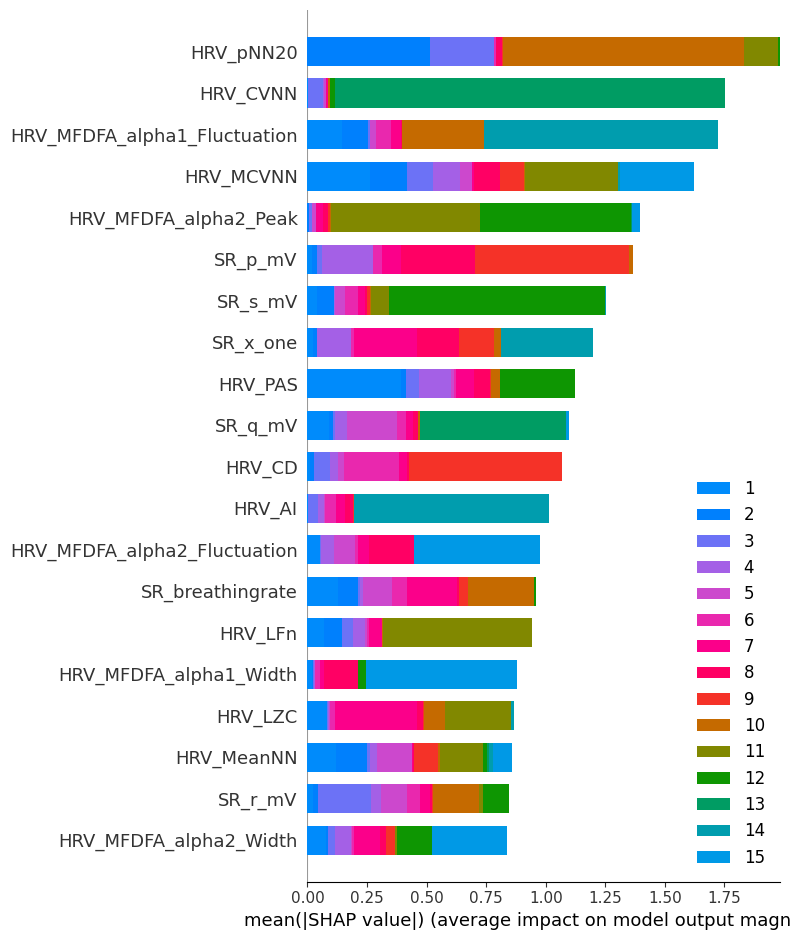

In [13]:
# check this out: https://stackoverflow.com/questions/71753428/how-to-get-shap-values-for-each-class-on-a-multiclass-classification-problem-in
class_names = np.fromiter(config.AGE_GROUPS, dtype=int)
shap.summary_plot(shap_values, x, class_inds="original", class_names=class_names)

1


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


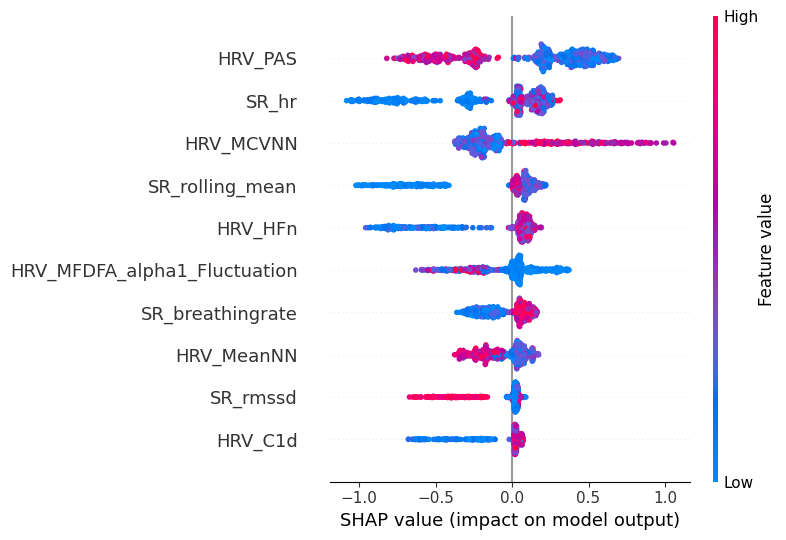

2


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


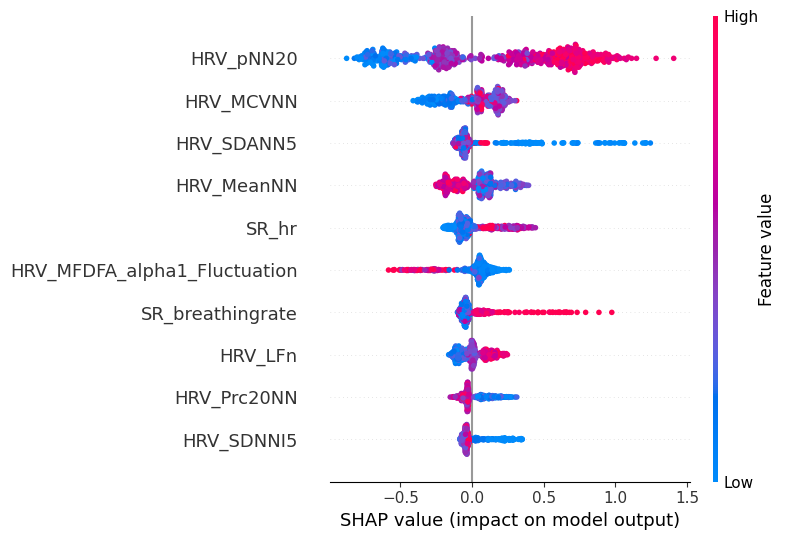

3


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


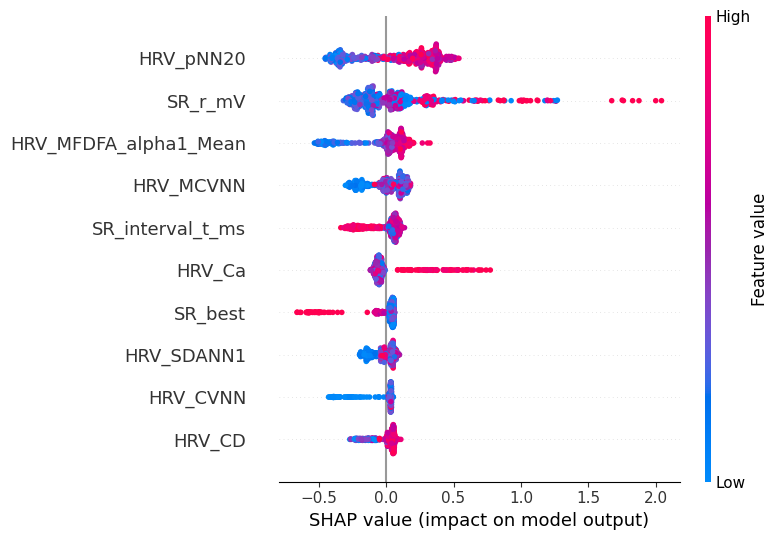

4


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


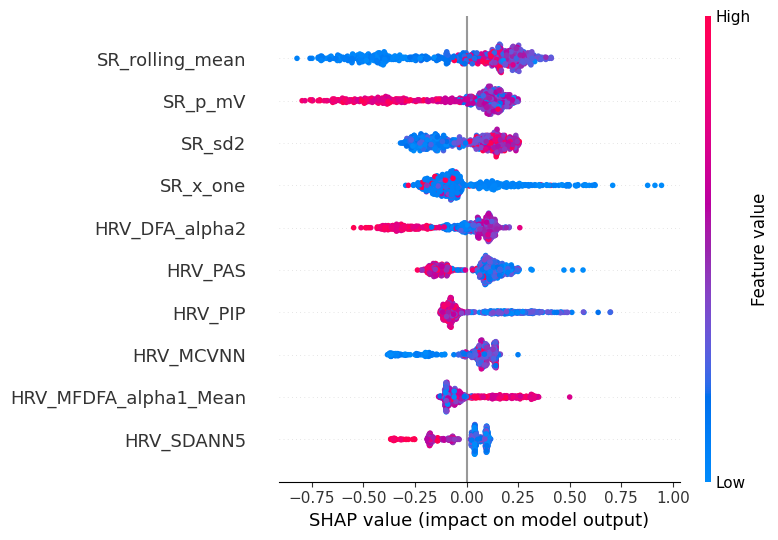

5


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


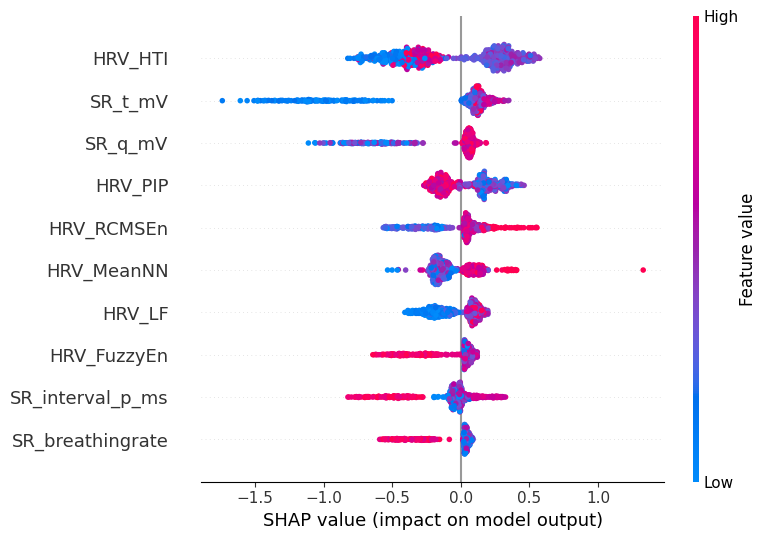

6


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


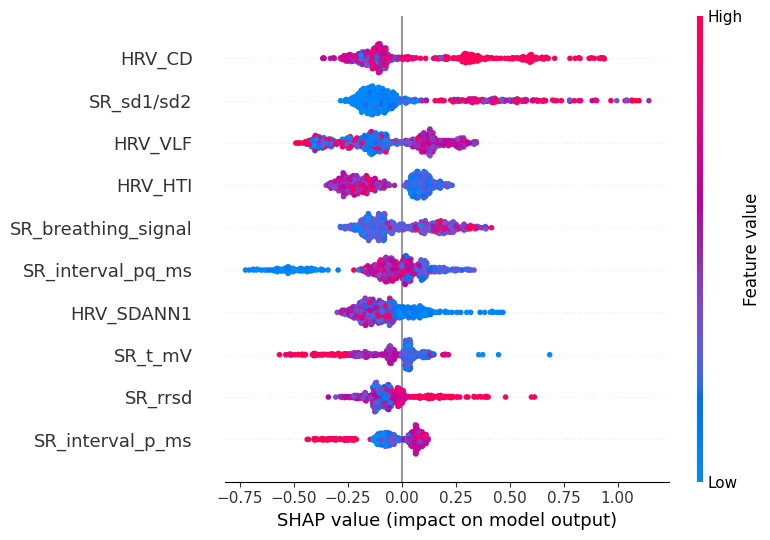

7


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


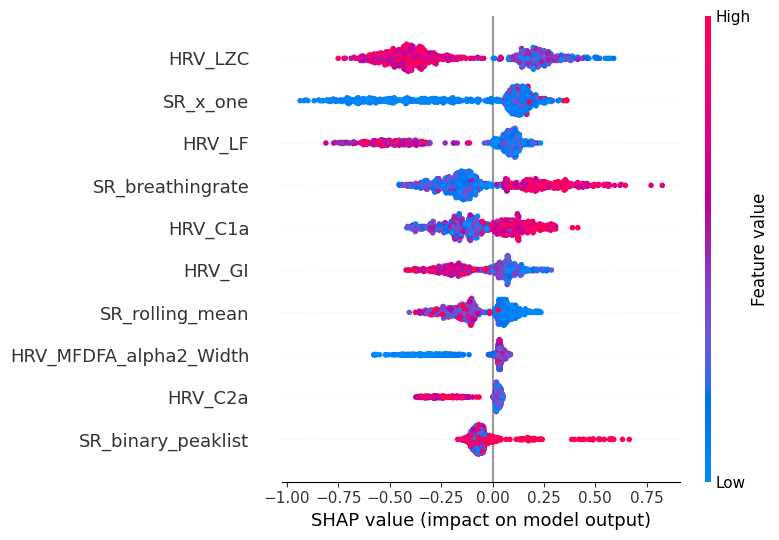

8


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


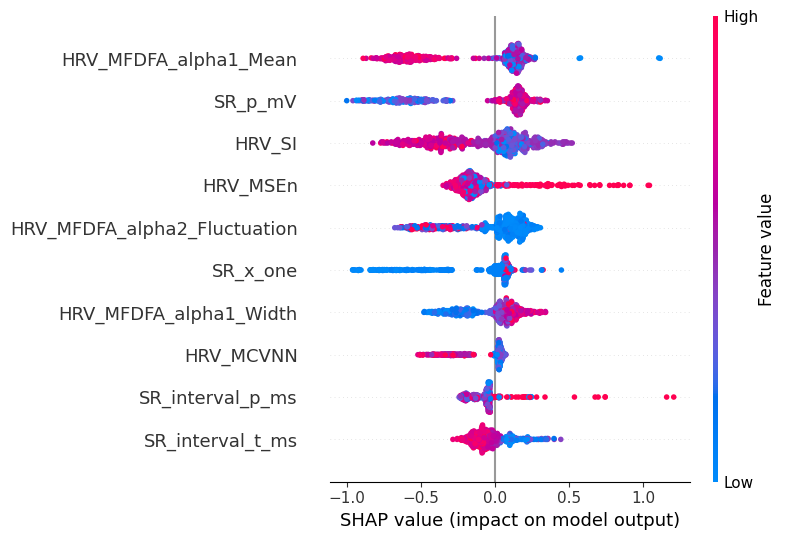

9


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


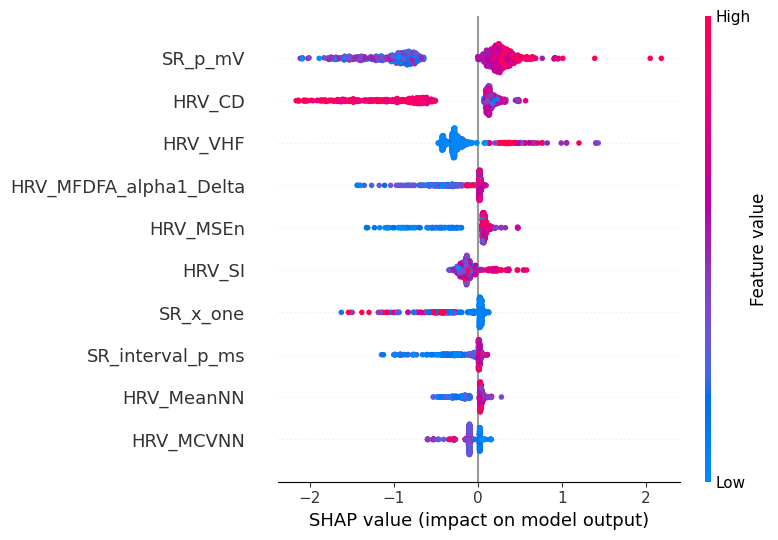

10


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


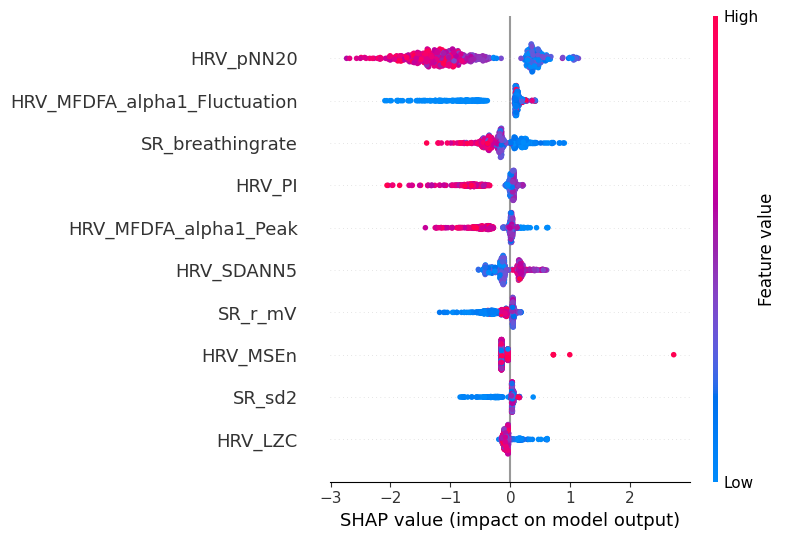

11


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


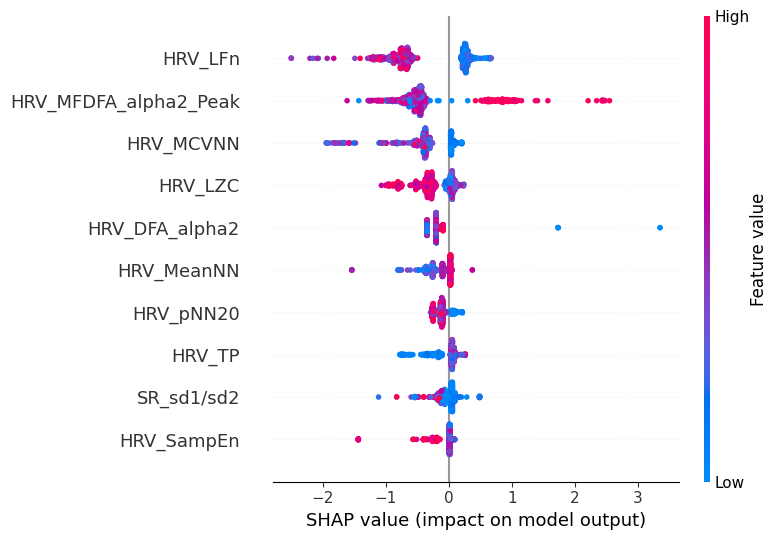

12


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


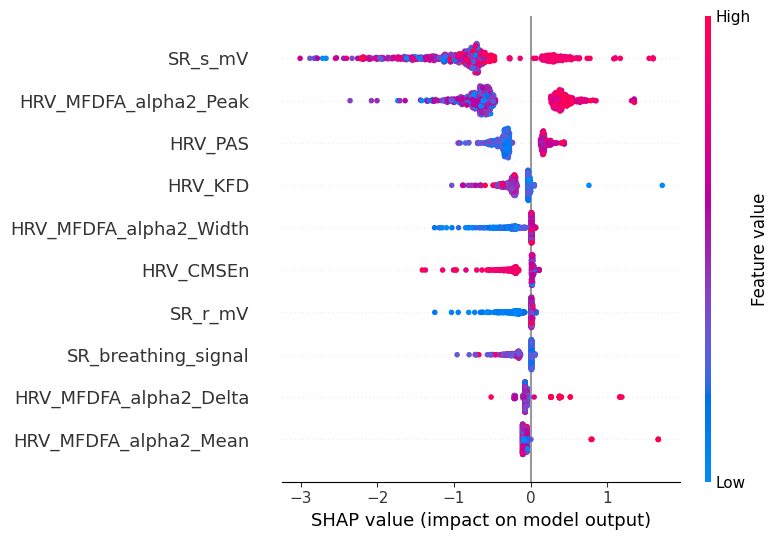

13


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


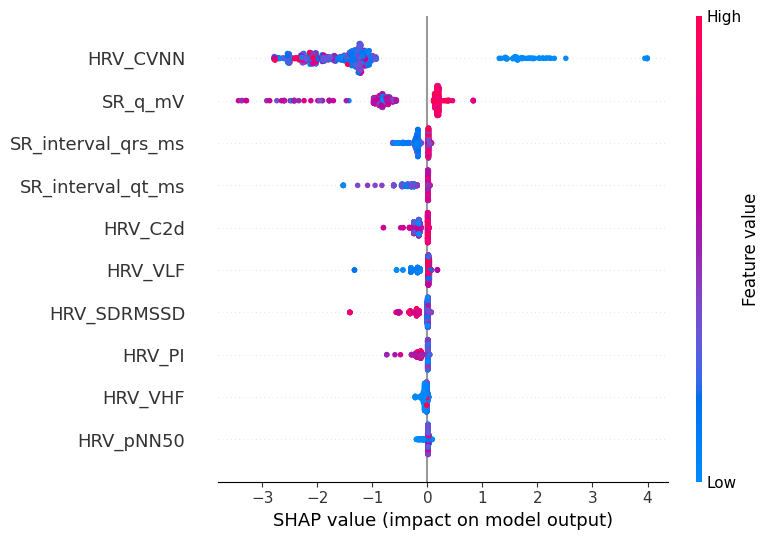

14


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


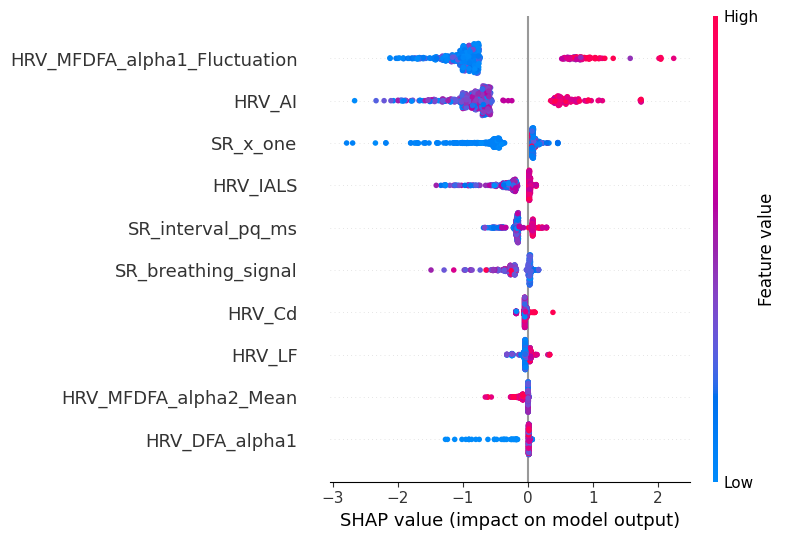

15


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


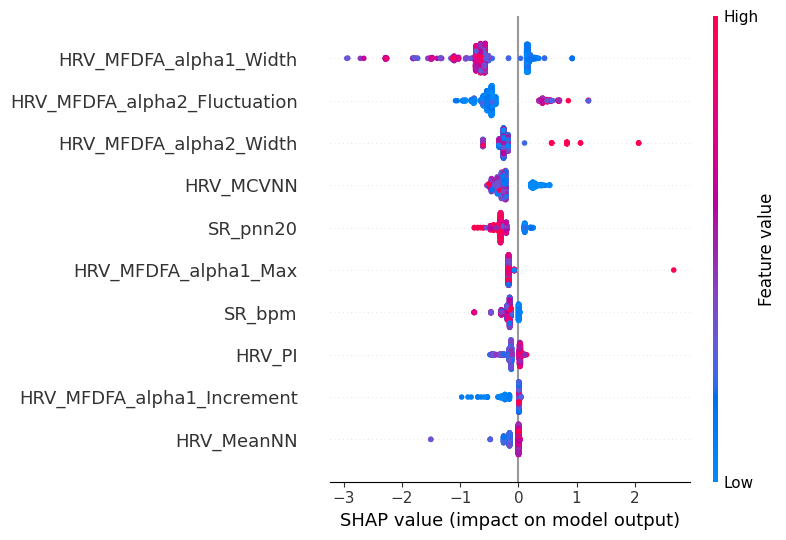

In [14]:
# do individual plots, get the 10 most influential features per class
# don't know what the features are? look here: https://neuropsychology.github.io/NeuroKit/functions/hrv.html#neurokit2.hrv.hrv_time
SAVE_FIG = True
#cmap='hsv' #change colors, see https://github.com/shap/shap/issues/62 for other solutions
for label in class_names:
    print(label)
    if SAVE_FIG:
        # for saving: https://stackoverflow.com/questions/52137579/save-shap-summary-plot-as-pdf-svg
        shap.summary_plot(shap_values[label-1], x, max_display=10, show=False)#, cmap=cmap)
        plt.savefig(os.path.join(config.OUT_FOLDER, f'shap_summary_label_{str(label)}_new.pdf'),dpi=600)
        plt.show() # clear plt-buffer, otherwise the plots look weird
    else:
        shap.summary_plot(shap_values[label-1], x, max_display=10)#, cmap=cmap)
        plt.show()
    